# Bayesian Monthly Sensitivity Model

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import nest_asyncio
nest_asyncio.apply()
import stan


%matplotlib inline

In [37]:
states=['Aberdeenshire','Londonderry', 'Suffolk', 'Norfolk', 'Kent']

In [96]:
# for use with big df with all counties - sel;ecting appropriate regions
wheat_temp=pd.read_csv('/Users/aa2572/Code/SimFarm2030/notebooks/Wheat_AllCntys_temp_anom.csv',  delimiter=',', index_col=[0,1])
idx=pd.IndexSlice
temp_states = wheat_temp.loc[idx[states,:], :]

In [89]:
yields=pd.read_table('/Users/aa2572/Code/SimFarm2030/notebooks/Wheat_median_yield_anom.csv', delimiter=',', index_col=0)
yields = yields.drop(columns=['location_avg','location_median'])

In [97]:
# type(yields.columns)  => pandas.core.indexes.base.Index
good_yrs = yields.columns.astype(np.int64)
good_yrs

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017],
           dtype='int64')

In [98]:
# filter temp states
# temp_states.loc['Norfolk', :].index - not strings
# temp_state = temp_states.loc['Norfolk'].loc[good_yrs] - > correct, same as below.

# temp_states.xs(good_yrs, level=1)  2013, 2014, 2015, 2016, 2017], dtype='int64')' is an invalid key
temp_state = temp_states.loc[(states,good_yrs),:]

In [99]:
temp_state

Jan       Feb       Mar       Apr       May  \
County        Year                                                     
Aberdeenshire 2002 -0.007965 -0.025607 -0.163259 -0.444801 -0.716103   
              2003 -0.198551 -1.022673  0.596262  0.019557 -0.750410   
              2004 -0.296895 -0.159561 -0.443990  0.248019 -0.415128   
              2005  1.033442 -0.373199  0.316751 -0.779215 -1.926687   
              2006  0.099153 -0.535175 -2.817811 -1.295431 -1.669308   
...                      ...       ...       ...       ...       ...   
Kent          2013  0.197313 -0.746662 -1.927531  0.003567  0.124978   
              2014  2.980154  3.196963  3.015567  3.398491  2.169254   
              2015  1.318088  0.647864  1.482743  1.701053  1.363974   
              2016  2.077553  1.724654  0.925529  0.715011  2.573628   
              2017 -0.219450  2.767631  3.943993  1.958858  2.984855   

                         Jun       Jul       Aug       Sep       Oct  \
County        Year                                                     
Aberdeenshire 2002 -1.216476 -1.954118 -0.562503 -0.857097 -2.539831   
              2003  0.088557  0.101756 -0.205933 -1.002988 -2.113776   
              2004 -0.639130 -2.332567 -0.575324 -0.836355 -0.996954   
              2005 -0.643813 -1.171255 -1.574062 -0.534542  0.243862   
              2006 -0.356085  0.884575 -1.091058  0.790412  0.752131   
...                      ...       ...       ...       ...       ...   
Kent          2013  0.446002  2.777757  2.787240  1.489747  3.104600   
              2014  1.955509  3.277646  1.179054  2.994603  4.126483   
              2015  1.656713  2.211470  2.178448  0.410168  1.672720   
              2016  1.818751  2.377294  3.011306  4.584079  1.827320   
              2017  3.665202  2.766659  1.811779  1.268640  3.163713   

                         Nov       Dec  
County        Year                      
Aberdeenshire 2002  0.341029  0.372330  
              2003  0.189557 -0.783554  
              2004 -0.165076 -0.200085  
              2005 -1.315700 -0.311311  
              2006  0.065860 -0.508561  
...                      ...       ...  
Kent          2013  0.795184  2.189724  
              2014  3.390747  1.449313  
              2015  4.015379  6.064058  
              2016  0.642427  1.968545  
              2017  1.008228  0.789740  

[80 rows x 12 columns]

In [100]:
# Compile model
with open('stan/BMSM-simp.stan', 'r') as f:
    model = f.read()
# sm = stan.build(f, data=data)


In [46]:
# filter out the index/year that dont matter to get just the years of interest 2002 - 2017 ** use temp_state instead
n_years=yields.columns.size
data={
    'n_regions':len(states),
    'n_years':n_years,
    'd_temp':np.array(temp_state).reshape(len(states), len(good_yrs), 12),
    'd_yields':np.array(yields.loc[states].fillna(0.0)).astype(float)
}

In [101]:
sm = stan.build(model, data=data)
# RuntimeError: Error calling get_param_names: `Exception: mismatch in dimension declared and found in context; processing stage=data initialization; variable name=d_temp; position=1; dims declared=(1,18,12); dims found=(1,138,12) (in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_9nmcdiyk/model_2wdzshqy.stan', line 4, column 0 to column 34)`
# need to change the weather to just be the 18 years

# Warning in '/var/folders/m7/fqkk2h3d5rlbg6_z4yfy3dc4000z5d/T/httpstan_8ls7lxt3/model_2wdzshqy.stan', line 28, column 24: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
#  need to get anomilies for the weather in order to continue. 15/7/22

Building...



Building: 17.1s, done.Messages from stanc:
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_qke9eglz/model_yiiyjxif.stan', line 28, column 36: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).


In [102]:
fit=sm.sample(num_chains=4,num_samples=1000)
type(fit)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/8000)
Samplin

stan.fit.Fit

In [103]:
df = fit.to_frame()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4000.0,-41.285111,5.482499,-63.242886,-44.826086,-40.972033,-37.402438,-25.036781
accept_stat__,4000.0,0.901446,0.096351,0.338054,0.857062,0.930729,0.975755,1.000000
stepsize__,4000.0,0.072478,0.001435,0.070781,0.071203,0.072534,0.073809,0.074064
treedepth__,4000.0,5.992500,0.237609,5.000000,6.000000,6.000000,6.000000,7.000000
n_leapfrog__,4000.0,73.192000,25.160473,31.000000,63.000000,63.000000,63.000000,255.000000
...,...,...,...,...,...,...,...,...
d_yields_pred.2.16,4000.0,0.760106,1.296378,-3.679009,-0.122751,0.771700,1.612574,5.142554
d_yields_pred.3.16,4000.0,0.963229,1.408302,-4.412831,0.031024,0.965986,1.915249,6.539518
d_yields_pred.4.16,4000.0,0.835499,1.399888,-4.162955,-0.088299,0.833755,1.774889,5.754743


In [104]:
fit['d_yields_pred']

array([[[ 2.88454319e+00,  5.46539424e-01, -1.14337147e+00, ...,
          4.21347265e-01,  1.36346522e+00,  9.56766186e-01],
        [ 2.51687125e+00, -1.49673613e+00, -1.62383713e+00, ...,
         -3.43744100e+00,  1.54510113e+00,  4.10798503e-01],
        [-7.05473070e-01,  1.44624616e+00,  1.40874390e+00, ...,
         -4.23703842e-01,  5.30550526e-01,  2.54597895e+00],
        ...,
        [ 3.13204994e-02, -1.03159178e+00, -4.83664767e+00, ...,
         -8.70635790e-01, -3.89531920e+00, -1.85598887e+00],
        [-1.17719515e+00,  4.80809813e-01,  9.22958895e-01, ...,
         -1.60407808e+00,  1.02094165e+00,  2.23236095e+00],
        [ 2.22502730e-01, -2.28235990e-01, -1.59081551e+00, ...,
         -5.01772726e-01, -6.35315062e-01, -1.80741517e+00]],

       [[-2.28910199e+00,  1.80115178e+00,  2.62022207e-01, ...,
         -4.24550489e-01, -8.43492189e-01, -2.75775800e+00],
        [ 1.15153776e+00, -3.26900901e+00,  1.86555233e+00, ...,
         -1.92227798e+00,  2.32987951e

In [105]:
# from https://github.com/grburgess/stan_utility/blob/master/stan_utility/utils.py
def check_div(fit, quiet=False):
    """Check transitions that ended with a divergence"""
    # sampler_params = fit.sample_and_sampler_param_names
    # divergent = [x for y in sampler_params for x in y["divergent__"]]
    divergent = fit["divergent__"][0]
    n = sum(divergent)
    N = len(divergent)

    if not quiet and n > 0:
        print(
            "{} of {} iterations ended with a divergence ({}%)".format(
                n, N, 100 * n / N
            )
        )
        # return 'jokes'

    if n > 0:
        if not quiet:
            print("  Try running with larger adapt_delta to remove the divergences")
            # return 'here'
        else:
            return False
    else:
        if quiet:
            return True
        # else:
        #     return 'silly'


def check_treedepth(fit, max_treedepth=10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # depths = [x for y in sampler_params for x in y["treedepth__"]]
    depths = fit['treedepth__'][0]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet and n > 0:
        print(
            (
                "{} of {} iterations saturated the maximum tree depth of {}" + " ({}%)"
            ).format(n, N, max_treedepth, 100 * n / N)
        )
    if n > 0:
        if not quiet:
            print(
                "  Run again with max_treedepth set to a larger value to avoid saturation"
            )
        else:
            return False
    else:
        if quiet:
            return True


def check_energy(fit, quiet=False):
    """Checks the energy fraction of missing information (E-FMI)"""
    # sampler_params = fit
    no_warning = True
    for chain_num, energies in enumerate(fit['energy__']):
        # energies = s["energy__"]
        numer = sum(
            (energies[i] - energies[i - 1]) ** 2 for i in range(1, len(energies))
        ) / len(energies)
        denom = np.var(energies)
        if numer / denom < 0.2:
            if not quiet:
                print("Chain {}: E-BFMI = {}".format(chain_num, numer / denom))
            no_warning = False

    if no_warning:
        if quiet:
            return True
    else:
        if not quiet:
            print(
                "  E-BFMI below 0.2 indicates you may need to reparameterize your model"
            )
        else:
            return False


In [106]:
# carry out some diagnostic checks on fit
# import stan_utility
check_div(fit)
check_energy(fit)
check_treedepth(fit)

In [107]:
posterior = stan.build(model, data=data, random_seed=5)
pfit = posterior.sample(num_chains=4, num_samples=150)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/9d/1g0lys2908z0ckh1zkc_q1z8000z5d/T/httpstan_qke9eglz/model_yiiyjxif.stan', line 28, column 36: Argument 100.0 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4600)
Sampling:   0% (2/4600)
Sampling:   0% (3/4600)
Sampling:   0% (4/4600)
Sampling:   2% (103/4600)
Sampling:   4% (202/4600)
Sampling:   7% (301/4600)
Sampling:   9% (400/4600)
Sampling:  11% (500/4600)
Sampling:  13% (600/4600)
Sampling:  15% (700/4600)
Sampling:  17% (800/4600)
Sampling:  20% (900/4600)
Sampling:  22% (1000/4600)
Sampling:  24% (1100/4600)
Sampling:  26% (1200/4600)
Sampling:  28% (1300/4600)
Sampling:  30% (1400/4600)
Sampling:  33% (1500/4600)
Sampling:  35% (1600/4600)
Sampling:  37% (1700/4600)
Sampling:  39% (1800/4600)
Sampling:  41% (1900/4600)
Sampling:  43% (2000/4600)
Sampling:  48% (2200/4600)
Sampling:  50% (230

Text(0.5, 1.0, 'Monthly Temperature Anomolies by County')

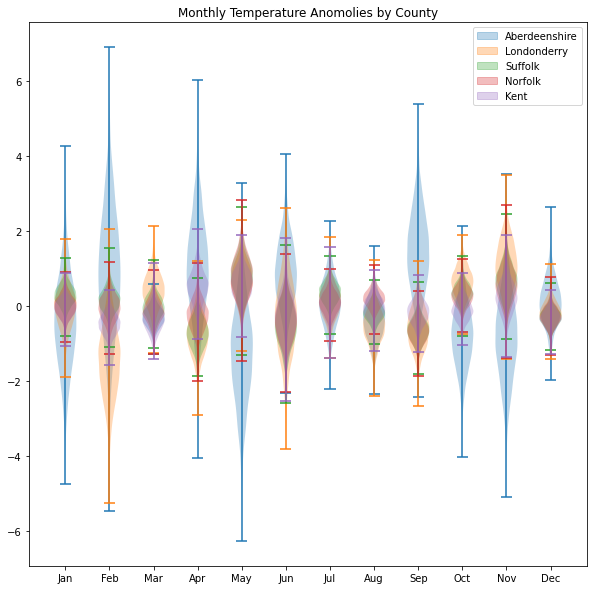

In [108]:
# changes samples to fit (shape 35,4000) not right
plt.figure(figsize=(10,10))
import matplotlib.patches as mpatches

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


for i in range(0,len(states)):
    add_label(plt.violinplot(fit['s_temp'].T[:,:,i]), f'{states[i]}')
    plt.xticks(range(1,13),wheat_temp.columns);
    plt.legend(*zip(*labels), loc=1)
plt.title('Monthly Temperature Anomolies by County')

Text(0.5, 1.0, 'Monthly predicted yield anomolies by County')

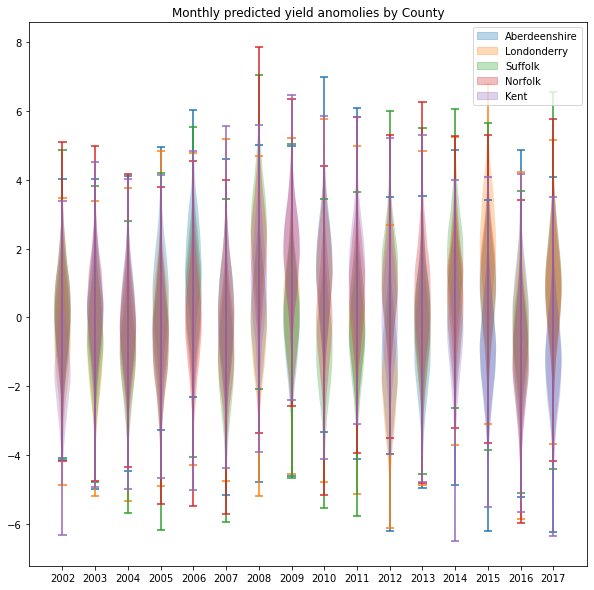

In [61]:
# changes samples to fit (shape 35,4000) not right
plt.figure(figsize=(10,10))
import matplotlib.patches as mpatches

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))


for i in range(0,len(states)):
    add_label(plt.violinplot(fit['d_yields_pred'].T[:,:,i]), f'{states[i]}')
    plt.xticks(range(1,17),good_yrs);
    plt.legend(*zip(*labels), loc=1)
plt.title('Monthly predicted yield anomolies by County')

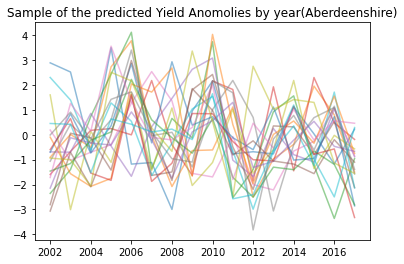

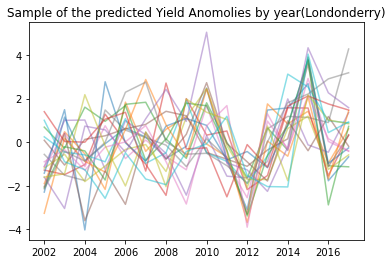

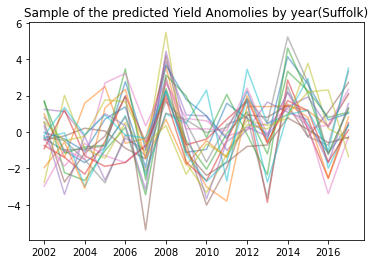

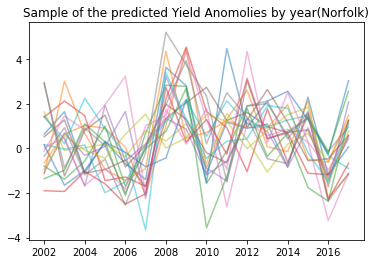

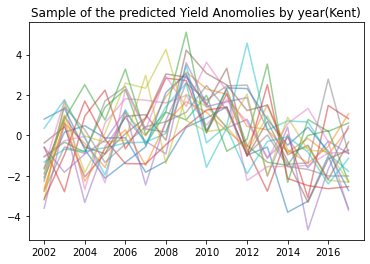

In [79]:
for i in range(0, len(states)):
    plt.figure()
    for s in range(0,4000,200):  # changed from 2000 to 600 for wheat  what is s, just a sample of the sample yield predictions?
        plt.plot(range(2002,2018),fit['d_yields_pred'].T[s,:,i].T,alpha=0.5)
        plt.title(f'Sample of the predicted Yield Anomolies by year({states[i]})')

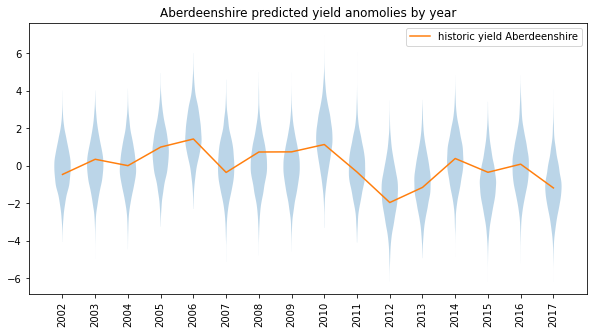

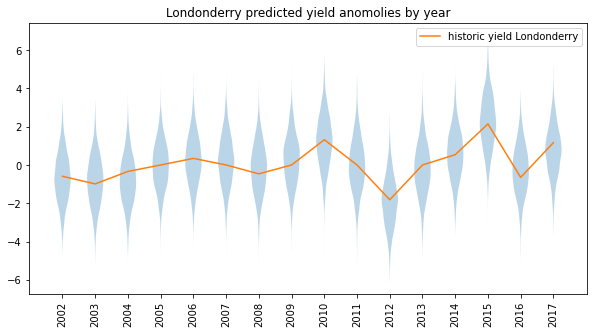

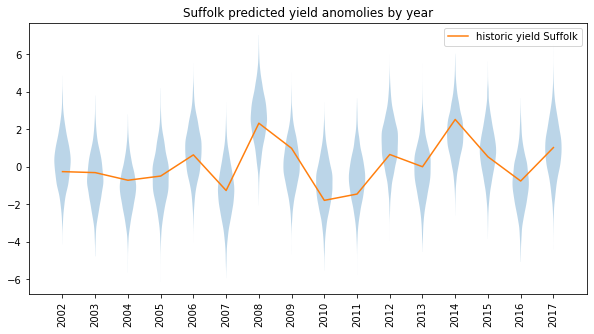

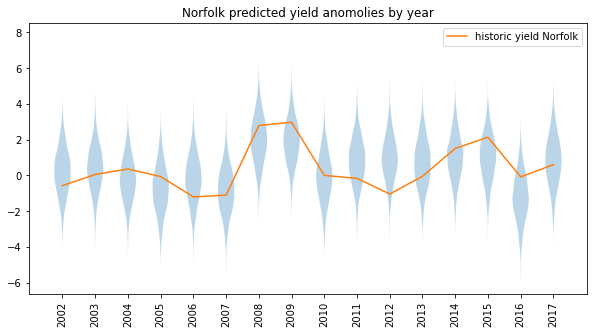

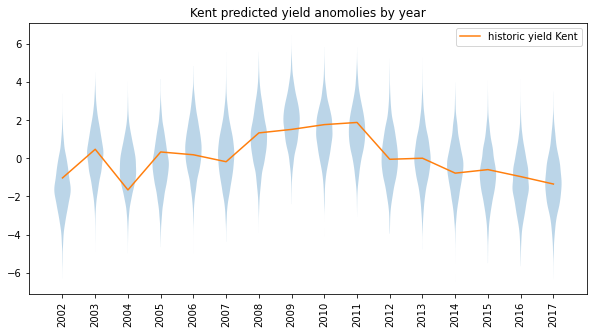

In [81]:
for i in range(0, len(states)):   
    plt.figure(figsize=(10,5))
    # plt.violinplot(fit['d_yields_pred'][:,0,:].T,showextrema=False); transpose the d_yields_pred and change the slice (0 to the end because thats where the index is only 2)
    plt.violinplot(fit['d_yields_pred'].T[:,:,i],showextrema=False);
    plt.xticks(range(1,17),np.arange(2002,2018),rotation=90);
    plt.plot(range(1,17),data['d_yields'][i,:], label=f'historic yield {states[i]}')
    plt.title(f'{states[i]} predicted yield anomolies by year' )
    plt.legend()


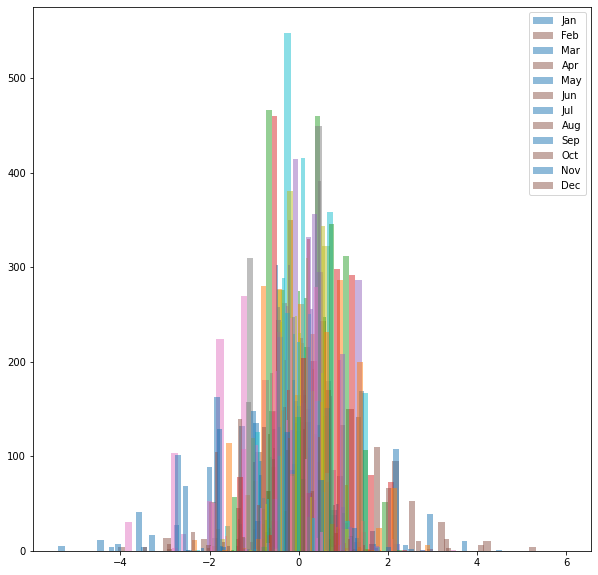

In [109]:
plt.figure(figsize=(10,10))
for i in range(0,12):
    plt.hist(pfit['s_temp'].T[:,i,:], alpha=0.5,label=wheat_temp.columns[0:][i])
plt.legend()

In [111]:
plt.figure(figsize=(10,10))
plt.violinplot(pfit['mu'].T[:,:,0]);
plt.xticks(range(1,13),wheat_temp.columns[1:]);

AssertionError: mu

<Figure size 720x720 with 0 Axes>

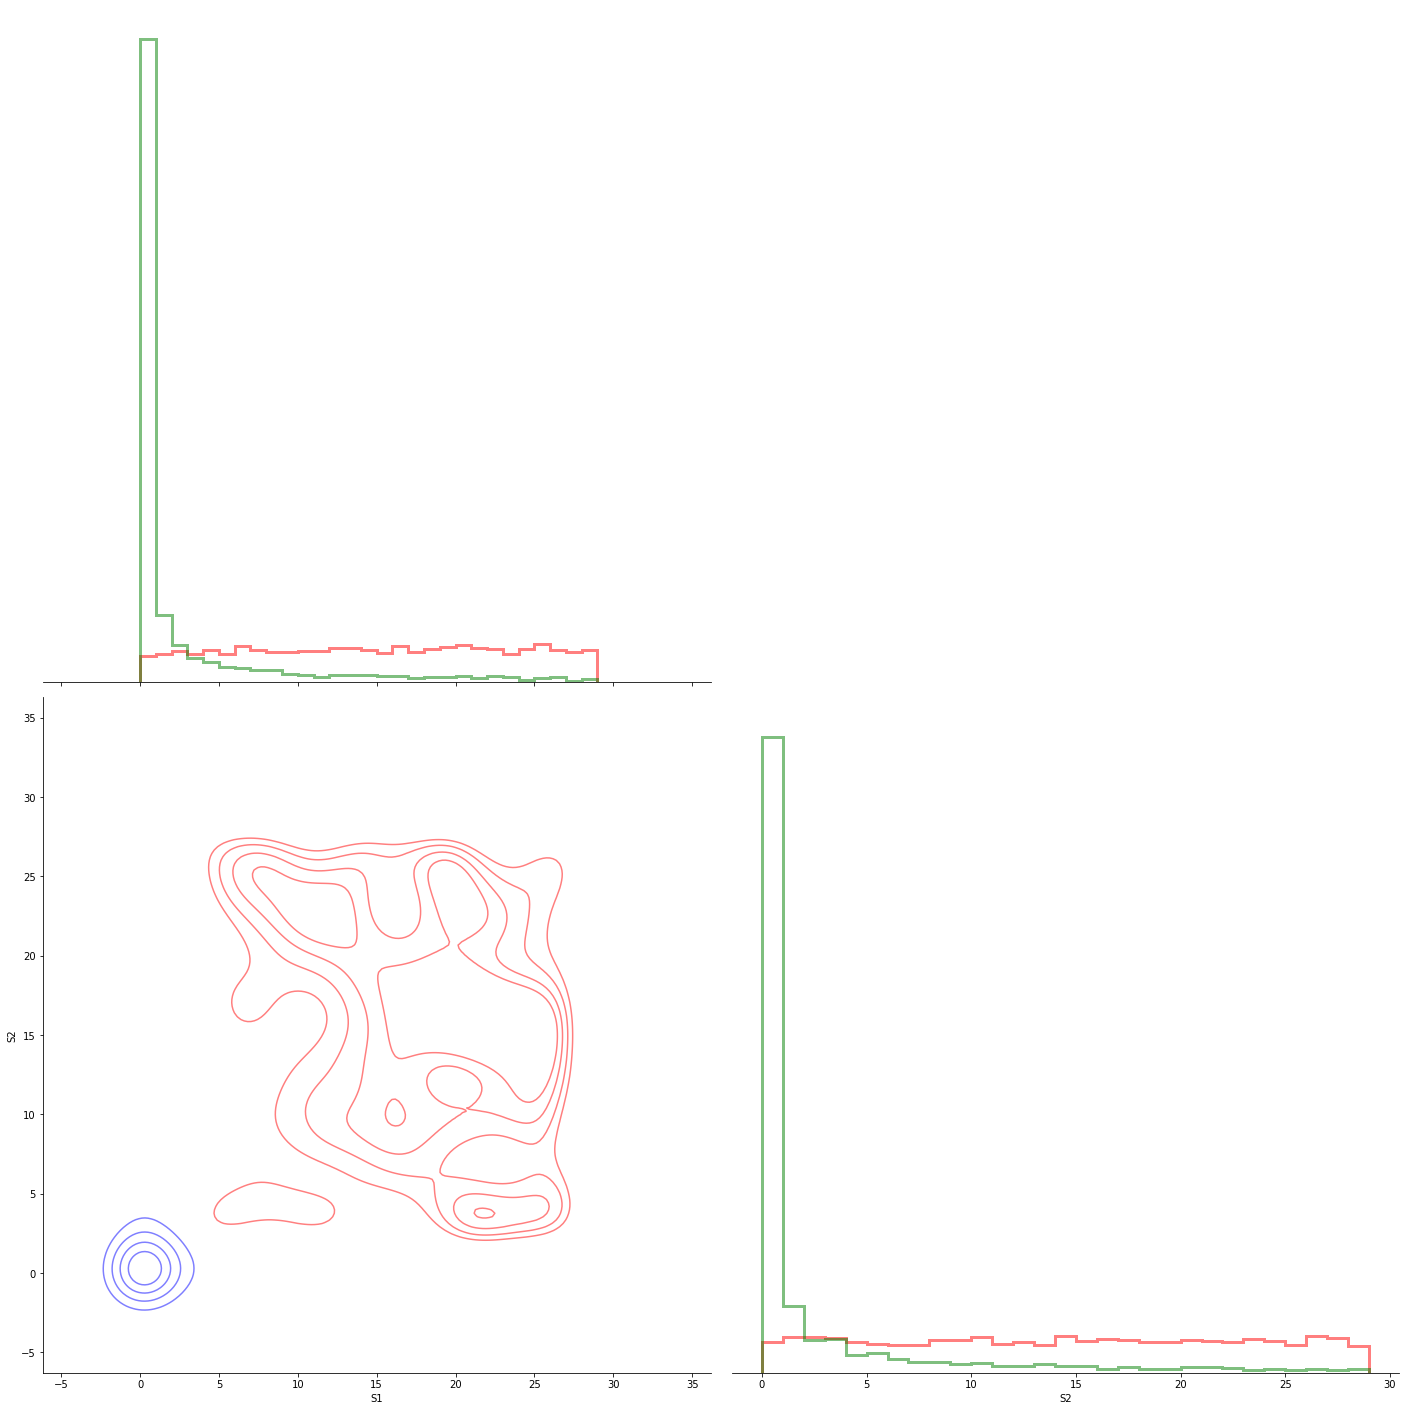

In [233]:
# posterior samples from prior?
import seaborn as sns
import scipy.stats as stats
import numpy as np
cmap=['Red','Blue','Green']#colors for contours
# randomly sample points from uniform distribution and put into dataframe
df_uniform=pd.DataFrame(np.vstack((stats.uniform(0.001,30).rvs(5000),
                                   stats.uniform(0.001,30).rvs(5000))).T,
                        columns=['S1','S2'])
#randomly sample from log uniform and put in dataframe
df_loguniform=pd.DataFrame(np.vstack((stats.loguniform(0.001,30).rvs(5000),stats.loguniform(0.001,30).rvs(5000))).T,columns=['S1','S2'])
bins=np.arange(0,30,1)
#use seaborn pairgrid plot for uniform dist
g=sns.PairGrid(df_uniform,corner=True,height=10)
#plot histogram on diagonal
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[0],bins=bins)
#change data to log uniform
g.data=df_loguniform
#overplot histogram for loguniform
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[2],bins=bins)
# plot contours on bottom left plot by assigning the relevant dataframe and crating map lower plot using a kernel denisty estimator
for i,df in enumerate([df_uniform,df_loguniform]):
    g.data=df
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=5, shade=False,thresh=0.5)